<h1><Center>
    PROJET COMPAGNON
    
    *
    PROPAGATION D'UN VIRUS
</h1>

# I. Introduction

## A. Contexte

<p>Dans ce projet compagnon nous allons étudier la propagation d'un virus au sein d'une population. Ce domaine d'étude qui date du début du XXème siècle est primordiale pour comprendre les dynamiques épidémiques.  Via une modélisation mathématique les experts et les élus peuvent prendre de meilleure décisisons pour cet enjeux de santé publique.[1][6]

Les études se découpent généralement en fonction de la taille de population considéré. En dessous de mille individu on peut considerer des modèles discrets. Pour les echelles superieurs un modèle deterministe à temps continu est privilégié (simplicité mise en équation, coup de calcul ...). [2]

Il existe differents modèles en fonction la maladie (mode de transmission, immunisation, ...) mais aussi des niveaux de raffinements dans la modélisation avec plus de: paramètres, d'états de la maladie, et de flux possibles. On peut se retrouver rapidement avec des système differentiels de plusieurs equations dépendant de nombreuses variables. 

Nous allons nous interer à 2 modèles à temps continu, les plus répendus, car permettant une modélisation s'approchant de la réalité avec une puissance de calcul attégnable par un ordinateur personnel. 
Nous verrons d'abord le modèle SI puis le modèle SIR.</p>

## B. Notations

<p>Nous exposons ici les differents parametres qui reviendront dans les modèles étudiés.

   - N nombre d'individu de la population considéré comme constant au court du temps

A un instant t la population est divisée en plusieurs catégories disjointes en fonction des modèles:

   - S susceptibles: individus qui ne sont pas malades mais sont susceptibles de le devenir
   - I infectieux: individus malades et capables de transmettre l’infection
   - R retirés: individus qui ont contracté la maladie et qui ne peuvent plus la transmettre (immunisés de façon permanente, isolés, morts)</p>

## C. Hypothèses

- La maladie est transmise par contact direct entre infectés et susceptibles.
- Tous les susceptibles le sont uniformémement et tous les infectés sont également contagieux. 
- La taille de la population reste fixée, égale à N
- Les effectifs sont suffisamment grand devant les variations temporelles l'on considère les fonctions derivables en fonction du temps


# II. Developpement

Présentons à présent nos differents modèles épémiques.

## A. Modèle SI

### 1/ Contexte

Ce modèle divise la population en deux catégories. D'un coté les suseptible et de l'autre coté les infectés. Il s'agit d'une maladie hautement contagieuse mais pas foudrouillante (pour qu'il  y est un contact permanent infecté suseptible). De plus les individus ne guerissent pas de la maladie sur l'echelle de temps considéré.

![Schéma SI](../Desktop/Capture%20d%E2%80%99e%CC%81cran%202023-03-06%20a%CC%80%2010.03.48.png)

### 2/ Modélisation

On obtient le système differentiel suivant.

$\left\{\begin{matrix}
\frac{\mathrm{d}S(t))}{\mathrm{d} t}= -\frac{\beta}{N} S(t)I(t) \; \; (1)  \\ \\
\frac{\mathrm{d}I(t))}{\mathrm{d} t}= \frac{\beta}{N} S(t)I(t) \; \;(2) \\ \\
\forall \: t \; S(t) + I(t) = N \; \; (3)\\ \\
\ S(0) = S_{0} \; et \; I(0) = I_{0} \; \; (4)
\end{matrix}\right.$

### 3/ Résolution théorique

#### 3.1 Solution du système differentiel

En prenant la ligne (2) du système, en réexprimant S par I grâce à (3) on obtient: 

$\frac{\mathrm{d}S(t))}{\mathrm{d} t}= -\frac{\beta}{N} (N-I(t))I(t)$ 

En procédent ensuite à un changement de variable du type

$ x(t)= \frac{1}{I(t)}$

on tombe une equation logistique : 

$\frac{\mathrm{d}x(t))}{\mathrm{d} t}= \beta x(t)$ 

en faisant le changement de variable pour retomber sur I, on obtient:

$I(t)=\frac{I_{0}Ne^{\beta t}}{S_{0} \ + \ I_{0}e^{\beta t}} \; (*)$ 

### 4/ Résolution numérique

#### 4.1 Mise en place de l'espace de travail

Import des differents packages qui nous serons utiles pour résoudre les équations, tracer les graphiques...

In [2]:
import numpy as np
import pandas as pd
import numba

import scipy
from scipy.optimize import fsolve #module pour trouver le zéro d'une fonction

from scipy import integrate #résoudre une équation differentielle de manière numérique
from scipy.integrate import odeint
import sympy as sym

import plotly.express as px # création de graphiques plus interactif que matplot
import matplotlib.pyplot as plt
import plotly.graph_objects as go

On code la fonction correspondant à la solution théorique $(*)$ pour pouvoir comparer la résolution numérique et théorique. On pourra ainsi voir à quel point les differentes méthodes exposées s'approchent correctement ou non de la solution réelle.

In [3]:
def solution(X0, t): 
    nt = len(t)
    X  = np.zeros([nt, len(X0)]) # création matrice que l'on remplira des valeurs de I et S à chaque instant
    for i in range(0,nt):
        It= (X0[1]*(X0[0]+X0[1])*np.exp(beta*t[i]))/(X0[0]+X0[1]*np.exp(beta*t[i]))
        St = N-It # calcul de S par difference avec I car la population totale est constante
        X[i,0], X[i,1] = St, It
    return(X)

#### 4.2 Initialisation des paramètres

In [4]:
# CONDITIONS INITIALES SUR LES COMPARTIMENTS
N = 1000. # nombre total d'individu dans notre population
I0 = 30. # nombre d'infecté initialement
S0 = N - I0  # nombre de suseptible initialement car population de taille fixe
X0 = S0, I0

# PARAMETRES DU VIRUS
beta = 0.7 # taux de contact infectant (unité: par jour)

# PARAMETRES TEMPORELLES
tmax = 15 # durée de la modélisation en jours
Nt = 30 # nombres de noeuds pour le maillage
T = np.linspace(0, tmax, Nt) # création du maillage

# PS: certains paramètres seront modifiés pour certains codes pour mettre en valeur des points particulier de l'EDP

#### 4.3 Fonction traduisant le système

On réecrit notre système sous la forme requise pour les schémas numériques.
A noter que l'on pourrait seulement calculer soit S, soit I puis soustraire à N. Nous retenons cette méthode par cohérence avec le modèles suivants (SIR).

In [5]:
def derivative_SI(X, t):
    S, I = X
    dS = -beta * S * I / N # ligne (2) du système
    dI = beta * S * I / N # ligne (3) du système
    return np.array([dS, dI])

#### 4.4 Euler Explicite

Le schéma numérique pour l'Euler Explicite est le suivant: 

$\begin{cases}
        z^{n+1} = z^{n}+\Delta tf(t^{n},z^{n}) \\
        z^{0} = y^{0}
     \end{cases}$

In [6]:
def Euler_Explicite(func, X0, t):
    dt = t[1] - t[0] # pas de temps
    nt = len(t)
    X  = np.zeros([nt, len(X0)])
    X[0] = X0 # conditions à t = 0 
    for i in range(nt-1):
        X[i+1] = X[i] + func(X[i], t[i]) * dt # schéma 
    return X

#### 4.5 Euler Implicite

### Euler Implicite


$\begin{cases}
        z^{n+1} = z^{n}+\Delta tf(t^{n+1},z^{n+1}) \\
        z^{0} = y^{0}
    \end{cases}$
    
Nous allons devoir utiliser la fonction lambda qui permet de trouver le zéro d'une fonction afin de déterminer z(t+1). Il faut annuler la fonction en x ci-dessous dont on connait tous les éléments : 

$g_{n}(x)=-x+z^{n}+\Delta t.derivative(t^{n+1},x)$


In [7]:
def Euler_Implicite(func, X0, t):
   
    dt = t[1] - t[0]
    nt = len(t)
    X  = np.zeros([nt, len(X0)])
    X[0] = X0 # conditions à t = 0
    for i in range(nt-1):
        func_eq = lambda Xnp : -Xnp + X[i] + dt * func(Xnp, t[i+1]) #zéro de la fonction
        X[i+1] = fsolve(func_eq, X[i])
    return X

#### 4.6 Comparaision des méthodes graphiquement

On obtient les valeurs pour chacunes des classes (S et I) à differents instants pour chacune des méthodes

In [8]:
XTH = solution(X0, T) # Solution Théorique
XEI =Euler_Implicite(derivative_SI, X0, T) # Solution Implicite
XEE = Euler_Explicite(derivative_SI, X0, T) # Solution Explicite

On convertit nos données sous forme pandas pour pouvoir les visualiser sur un graphique interactif pour pouvoir zoomer si besoin dans certaines zones. On peut cliquer sur les variables sur le coté pour les faire disparaitres si besoin et se concentrer que sur certaines courbes.

In [9]:
# Transformation en pandas
df = pd.DataFrame({'S_Imp':XEI[:,0] ,'I_Imp':XEI[:,1], 'S_Exp':XEE[:,0], 'I_Exp':XEE[:,1],'S_Th':XTH[:,0], 'I_Th':XTH[:,1]
                   }) 
df.insert(0, 'temps (en jours)', T) # ajout du temps en jours en colonne 1

# Affichage avec plotly
fig = px.line(df, x='temps (en jours)', y=['S_Imp','I_Imp','S_Exp','I_Exp','S_Th','I_Th'], labels=dict(index="temps (en jours)", value="nombre d'individus", title=""), title="Evolution du nombre d'individus seins et infectés pour differentes méthodes de résolution")
fig.show()


On remarque que pour un maillage fait avec 1 point tout les 2 jours la solution explicite est trop élevée pour S et la solution implicite donne une solution un peu en dessous de la réalité.

#### 4.7 Cas limites

Vérifions notre modèle sur des cas limites. On va prendre dans un cas beta nulle et dans l'autre I0 nulle, il ne doit pas y avoir de propagation de l'épidémie dans chacun de ses cas

##### 4.7.1 I(0) nulle

In [10]:
XEI =Euler_Implicite(derivative_SI, [100.,0], T) # Solution Implicite pour I0 = 0
XEE = Euler_Explicite(derivative_SI, [100.,0], T) # Solution Explicite pour I0 = 0

# Transformation en pandas
df0 = pd.DataFrame({'S_Imp':XEI[:,0] ,'I_Imp':XEI[:,1], 'S_Exp':XEE[:,0], 'I_Exp':XEE[:,1]
                   }) 
df0.insert(0, 'temps (en jours)', T) # ajout du temps en jours en colonne 1

# Affichage avec plotly
fig = px.line(df0, x='temps (en jours)', y=['S_Imp','I_Imp','S_Exp','I_Exp'], labels=dict(index="temps (en jours)", value="nombre d'individus", title=""), title="Evolution du nombre d'individus seins et infectés pour differentes méthodes de résolution")
fig.show()

La solution numérique est bien en accord avec la théorie

Remarque : cliquer sur les variables pour les faire disparaitre et voir qu'en dessous on a bien l'autre courbe !

##### 4.7.2 Beta nulle


In [11]:
beta = 0 # initialise beta = 0

XEI_Beta0 =Euler_Implicite(derivative_SI, [90.,10], T) # Solution Implicite 
XEE_Beta0 = Euler_Explicite(derivative_SI, [90.,0], T) # Solution Explicite 

# Transformation en pandas
dfb0 = pd.DataFrame({'S_Imp':XEI_Beta0[:,0] ,'I_Imp':XEI_Beta0[:,1], 'S_Exp':XEE_Beta0[:,0], 'I_Exp':XEE_Beta0[:,1]
                   }) 
dfb0.insert(0, 'temps (en jours)', T) # ajout du temps en jours en colonne 1

# Affichage avec plotly
fig = px.line(dfb0, x='temps (en jours)', y=['S_Imp','I_Imp','S_Exp','I_Exp'], labels=dict(index="temps (en jours)", value="nombre d'individus", title=""), title="Evolution du nombre d'individus seins et infectés pour differentes méthodes de résolution")
fig.show()

La solution numérique est bien en accord avec la théorie, I et S restent constants. 

Remarque : cliquer sur les variables pour les faire disparaitre et voir qu'en dessous on a bien l'autre courbe !

In [12]:
# On refixe beta comme initialement

beta = 0.7


### 5/ Impact des paramètres

#### 5.1 Impact des paramètres de l'équation

#### Beta

In [13]:
def solution_beta(X0, t, beta_min, beta_max, nombre_beta):  # on prend beta aussi en parametre
    dt = t[1] - t[0]
    nt = len(t)
    betas = np.linspace(beta_min, beta_max, nombre_beta)
    c = len(X0)*len(betas)
    X  = np.zeros([nt, c])
    
    for j in betas:
        for i in range(0,nt):
            It = (X0[1]*(X0[0]+X0[1])*np.exp(j*t[i]))/(X0[0]+X0[1]*np.exp(j*t[i])) # calcul via la solution réelle
            St = N-It
            p = betas.tolist().index(j)
            X[i,2*p],X[i,2*p+1]  = St, It
    return(X)

In [14]:
# On redéfinit T et X0 pour mieux voir
T_B = np.linspace(0, 30, 50)
X0 = 970., 30.

# Calcul de la solution théorique pour differents bétas
X_Beta = solution_beta(X0, T_B, 0.3, 1.5, 5) 

In [15]:
# Creation dictionnaire pour renommer les courbes avec les valeurs des betas
dictionnaire = {0: 'S_b_0.3',1: 'I_b_0.3',2: 'S_b_0.6',3: 'I_b_0.6',4: 'S_b_0.9',5: 'I_b_0.9',6: 'S_b_1.2',7: 'I_b_1.2', 8: 'S_b_1.5', 9: 'I_b_1.5' }    

# Transformation données en pandas
dbeta = pd.DataFrame(X_Beta)
dbeta.rename(columns=dictionnaire, inplace=True)
dbeta.insert(0, 'jours', T_B) # ajout du temps en jours en colonne 1

# Affichage du graphique
figure = px.line(dbeta, x='jours', y=['S_b_0.3','I_b_0.3','S_b_0.6','I_b_0.6','S_b_0.9','I_b_0.9','S_b_1.2','I_b_1.2','S_b_1.5','I_b_1.5'], labels=dict(index="temps (en jours)", value="nombre d'individus", title=""), title="Evolution du nombre d'individus seins et infectés pour differentes valeurs de betas")
figure.show()

Nous voyons que plus beta augmente et plus le nombre d'individu contaminé augmente rapidement. En effet, le beta est une des caractéristique majeurs pour comprendre à quel point la maladie va se transmettre. Les valeurs utilisées sont celles que l'on peut retrouver pour des épidémies qui se propagent moyennement rapidements (SIDA, VIH, Ebola, Rubeole ...). [4]

### 6/ Erreur

Regardons comment evolue l'erreur chaque jours (t)  en fonction du nombre de noeuds pour le maillage (Nt). 
L'erreur est définie de la manière suivante: 

$ erreur(t,Nt)= \left | S_{theorique}(t_{Nt})- S_{numerique}(t_{Nt}) \right |$

### 6.1 Erreur Euler Explicite

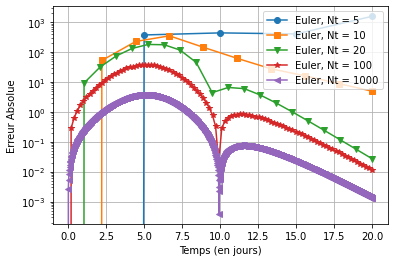

In [16]:
Nt_values = np.array([5, 10, 20, 100, 1000]) # choix du nombres de noeuds pour le maillage
tmax = 20


markers = "osv*<>"
plt.figure()
for i in range(len(Nt_values)):
    tvi = np.linspace(0., tmax, Nt_values[i])
    Xei = Euler_Explicite(derivative_SI, X0, tvi)
    Xsi = solution(X0, tvi)
    plt.plot(tvi, np.abs((Xei[:, 1] - Xsi[:, 1])), markers[i] + "-", label = "Euler, Nt = {0}".format(Nt_values[i]))

# affichage du graphique
plt.grid()
plt.xlabel("Temps (en jours)")
plt.yscale('log')
plt.ylabel("Erreur Absolue")
plt.legend(loc = "best");
plt.show()


On remarque que l'erreur diminue lors Nt augmente.
L'erreur est maximale au environ de 10 jours lorsque l'on a les plus grosses variations sur nos valeurs. On peut aussi noter que lorsque l'on fait 10 fois plus de points de maillage l'erreur est divisée par 10. 

### 6.2 Erreur Euler Implicite

/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



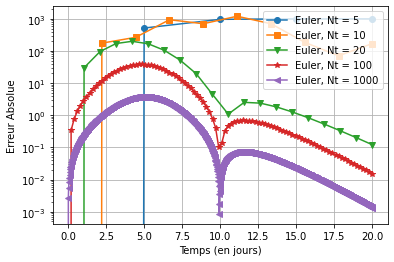

In [17]:
Nt_values = np.array([5, 10, 20, 100, 1000]) # choix du nombres de noeuds pour le maillage
tmax = 20

markers = "osv*<>"
plt.figure()
for i in range(len(Nt_values)):
    tvi = np.linspace(0., tmax, Nt_values[i])
    Xii = Euler_Implicite(derivative_SI, X0, tvi)
    Xsi = solution(X0, tvi)
    plt.plot(tvi, np.abs(Xii[:, 1] - Xsi[:, 1]), markers[i] + "-", label = "Euler, Nt = {0}".format(Nt_values[i]))

# affichage du graphique
plt.grid()
plt.xlabel("Temps (en jours)")
plt.yscale('log')
plt.ylabel("Erreur Absolue")
plt.legend(loc = "best");
plt.show()


### 6.3 Conclusion

On remarque que l'erreur est un peu plus élevé pour l'Euler implicite, ce qui ne devrait pas etre le cas normalement. Euler implicite est plus proche de la solution réelle normalement. [3]

### 7/ Ordre de Convergence

### 7.1 Convergence Euler Explicite

D'apèrs le cours pour un schéma d'Euler Explicite nous avons une consistance en  $ \Delta   t$

En supposant la consistance de la forme $\;e = Cte (\Delta t) ^{p}$ on a en passant en au logarithme (ie passer en echelle logarithmique)  $\;log(e) = p \, log(\Delta t)+ log(Cte)$. En tracant $\;log(e)$ en fonction de $log(\Delta t)$ et en comparant la droite identité on pourra déduire la valeur de $p$. 

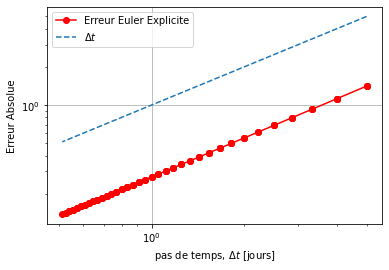

In [18]:
markers = "osv*<>"
tmax=20.
X0 = [100., 10.]

Nt_values = np.linspace(5., 40., 100).astype(np.int32)
dt_values = tmax / (Nt_values -1)
Erreur = []
for i in range(len(Nt_values)):
    tvi = np.linspace(0., tmax, Nt_values[i])
    Xei = Euler_Explicite(derivative_SI, X0, tvi)
    xsi = odeint(derivative_SI, X0, tvi)
    e = (Xei[:, 0] - xsi[:, 0]).std() # calcul de l'erreur
    Erreur.append(e)

plt.figure()
plt.plot(dt_values, Erreur, "or-", label = "Erreur Euler Explicite")
plt.plot(dt_values, dt_values, label = "$\Delta t$", linestyle ="--")
plt.legend()
plt.xlabel("pas de temps, $\Delta t$ [jours]")
plt.xscale('log')
plt.ylabel("Erreur Absolue")
plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.show()

Nous remarquons que les deux droites sont parallèles, en reprenant le paragraphe au dessus nous pouvons donc conclure que $p$ est égal à 1. 

### 7.1 Convergence Euler Explicite

D'apèrs le cours pour un schéma d'Euler Implicite nous avons une consistance en  $ \Delta   t$

Procédons de meme que précédement.

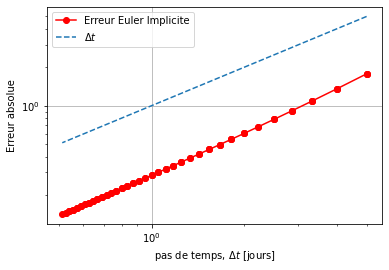

In [19]:
markers = "osv*<>"
tmax=20.
X0 = [100., 10.]

Nt_values = np.linspace(5., 40., 100).astype(np.int32)
dt_values = tmax / (Nt_values -1)
Error = []
for i in range(len(Nt_values)):
    tvi = np.linspace(0., tmax, Nt_values[i])
    Xei = Euler_Implicite(derivative_SI, X0, tvi)
    xsi = odeint(derivative_SI, X0, tvi)
    e = (Xei[:, 0] - xsi[:, 0]).std()
    Error.append(e)

plt.figure()
plt.plot(dt_values, Error, "or-", label = "Erreur Euler Implicite")
plt.plot(dt_values, dt_values, label = "$\Delta t$", linestyle ="--")
plt.legend()
plt.xlabel("pas de temps, $\Delta t$ [jours]")
plt.xscale('log')
plt.ylabel("Erreur absolue")
plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.show()

Nous retrouvons bien le meme résultat que celui énoncé en cours, c'est à dire une consistance en $ \Delta   t$

### 8/ Conclusion modèle SI

Nous voyons qu'avec les méthodes les plus basiques de résolutions numériques nous arrivons à approcher de manière fiable la solution théorique à condition d'avoir un maillage de taille minimale le jour. 

## B. Modèle SIR

### 1/ Contexte

Dans ce modèle on ne divise plus la population en deux mais trois catégories. Comme précédement nous avons les personnes saines S, les infectés I et enfin les personnes qui sont guéries R. Ce modèle est adapté pour des maladies où l'on peut etre immunisé avec une memoire immunitaire de l'ordre de grandeur au moins de la durée temporaille sesoniaire de l'épidémie. Ainsi les personnes rétablies ne peuvent pas retomber malade.

### 2/ Modélisation


On traduit le schéma ci-dessus. On obtient

![Schéma SIR](../../Capture%20d%E2%80%99e%CC%81cran%202023-03-06%20a%CC%80%2011.26.03.png)

On obtient le système differentiel suivant.

$\left\{\begin{matrix}
\frac{\mathrm{d}S(t))}{\mathrm{d} t}= -\frac{\beta}{N} S(t)I(t) \; \; (1)  \\ \\
\frac{\mathrm{d}I(t))}{\mathrm{d} t}= \frac{\beta}{N} S(t)I(t)-\gamma I(t) \; \;(2) \\ \\
\frac{\mathrm{d}R(t))}{\mathrm{d} t}= \gamma I(t) \; \;(3) \\ \\
\forall \: t \; S(t) + I(t) + R(t) = N \; \; (4)\\ \\
\ S(0) = S_{0} \; , \; I(0) = I_{0} \; et \;R(0) = R_{0} \; \; (5)
\end{matrix}\right.$

### 3/ Résolution théorique

#### 3.1 Solution du système differentiel

Il n'existe pas de solution générale à ce système. On peut exprimer des solutions en fonctions des autres types d'individus mais cela n'est pas possible en fonction du temps. 

### 4/ Résolution numérique

Ici la résolution numérique prend tout son sens car il n'existe pas de solution théorique contrairement au modèle SI.

#### 4.1 Initialisation des paramètres

In [20]:
# CONDITIONS INITIALES SUR LES COMPARTIMENTS
N = 1000. # nombre total d'individu dans notre population
I0, R0 = 30., 0. # nombre d'infecté initialement, nombre rétabli initialement
S0 = N - I0 - R0 #Susceptible individuals to infection initially is deduced
X0 = S0, I0, R0

# PARAMETRES DU VIRUS
beta = 0.7
gamma =  0.1

# PARAMETRES TEMPORELLES
tmax = 40 # durée de la modélisation en jours
Nt = 70 # nombres de noeuds pour le maillage
T = np.linspace(0, tmax, Nt+1)


#### 4.2 Fonction traduisant le système

On réecrit notre système sous la forme requise pour les schémas numériques.

In [21]:
def derivative_SIR(X, t):
    S, I, R = X
    dS = -beta * S * I / N
    dI = beta * S * I / N - gamma * I
    dR = gamma * I
    return np.array([dS, dI, dR])

#### 4.4 Euler Explicite

Le schéma pour Euler Explicite est le suivant: 

$\begin{cases}
        z^{n+1} = z^{n}+\Delta tf(t^{n},z^{n}) \\
        z^{0} = y^{0}
    \end{cases}$

In [22]:
def EulerExp(func, X0, t):
    dt = t[1] - t[0] # pas de temps
    nt = len(t)
    X  = np.zeros([nt, len(X0)])
    X[0] = X0 # conditions à t = 0
    for i in range(nt-1):
        X[i+1] = X[i] + func(X[i], t[i]) * dt #schéma
    return X

#### 4.5 Euler Implicite

Le schéma pour Euler Implicite est le suivant: 

$\begin{cases}
        z^{n+1} = z^{n}+\Delta tf(t^{n+1},z^{n+1}) \\
        z^{0} = y^{0}
    \end{cases}$
    
Nous allons devoir utiliser la fonction lambda qui permet de trouver le zéro d'une fonction afin de déterminer z(t+1). Il faut annuler la fonction en x ci-dessous dont on connait tous les éléments : 

$g_{n}(x)=-x+z^{n}+\Delta t.derivative(t^{n+1},x)$

In [23]:
def EulerImp(func, X0, t):
    dt = t[1] - t[0]
    nt = len(t)
    X  = np.zeros([nt, len(X0)])
    X[0] = X0
    for i in range(nt-1):
        func_eq = lambda Xnp : -Xnp + X[i] + dt * func(Xnp, t[i+1])
        X[i+1] = fsolve(func_eq, X[i])
    return X

#### 4.6 Comparaision des méthodes graphiquement

On obtient les valeurs pour chacune des classes (S, I et R) à differents instants pour chacune des méthodes.

In [24]:
XEI_SIR =EulerImp(derivative_SIR, X0, T) # Solution Implicite
XEE_SIR = EulerExp(derivative_SIR, X0, T) # Solution Explicite

In [25]:
# Transformation en pandas
dh = pd.DataFrame({'S_Imp':XEI_SIR[:,0] ,'I_Imp':XEI_SIR[:,1], 'R_Imp':XEI_SIR[:,2], 'S_Exp':XEE_SIR[:,0], 'I_Exp':XEE_SIR[:,1], 'R_Exp':XEE_SIR[:,2],
                   }) 
dh.insert(0, 'temps (en jours)', T) # ajout du temps en jours en colonne 1

# Affichage avec plotly
fig = px.line(dh, x='temps (en jours)', y=['S_Imp','I_Imp','R_Imp','S_Exp','I_Exp','R_Exp'], labels=dict(index="temps (en jours)", value="Nombre d'individus", title=""), title="Evolution du nombre d'individus de chacune des catégories pour differentes méthodes de résolution")
fig.show()

### 5/ Impact des paramètres

#### 5.1 Beta

On a choisi ici de faire une méthode un peu plus compliqué que juste prendre notre fonction derivative_SIR initiale et calculer pour differentes valeurs de beta. Le projet compagnon est surtout la pour monter en compétence en python, on en profite donc !

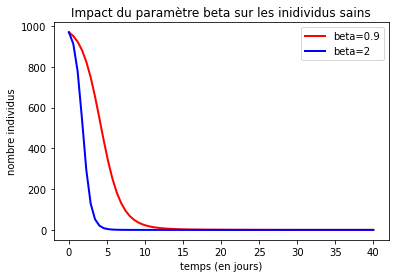

In [26]:
def derivative1(X, t, beti): # fonction prenant aussi beta en paramètre 
    S, I, R = X
    dotS = -beti * S * I / N
    dotI = beti * S * I / N - gamma * I
    dotR = gamma * I
    return np.array([dotS, dotI, dotR])


beti =0.9
X01 = odeint(derivative1, X0, T, args=(beti,))
beti =2
X03 = odeint(derivative1, X0, T, args=(beti,))

plt.plot(T,X01[:,0],'r-',linewidth=2,label='beta=0.9')
plt.plot(T,X03[:,0],'b-',linewidth=2,label='beta=2')
plt.title('Impact du paramètre beta sur les inidividus sains')
plt.xlabel('temps (en jours)')
plt.ylabel('nombre individus')
plt.legend()
plt.show()


#### 5.2 Gamma

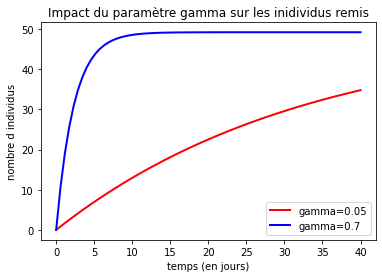

In [35]:
beta = 0.7 # refixe une valeur de beta, on s'interesse à gamma maintenant

def derivative2(X, t, gamma): # fonction prenant gamma en paramètre aussi
    S, I, R = X
    dotS = -beta * S * I / N
    dotI = beta * S * I / N - gamma * I
    dotR = gamma * I
    return np.array([dotS, dotI, dotR])

gamma =0.05
X07 = odeint(derivative1, X0, T, args=(gamma,))
gamma =0.7
X05 = odeint(derivative1, X0, T, args=(gamma,))

plt.plot(T,X07[:,2],'r-',linewidth=2,label='gamma=0.05')
plt.plot(T,X05[:,2],'b-',linewidth=2,label='gamma=0.7')
plt.title('Impact du paramètre gamma sur les inidividus remis')
plt.xlabel('temps (en jours)')
plt.ylabel('nombre d individus')
plt.legend()
plt.show()

#### 5.2 Beta & Gamma

On va faire varier les deux paramètres ensemble. Nous allons tester differents couples de valeurs que l'on peut retrouver pour des épidémies. [5] 

In [28]:
def derivative_R0(X, t, beta, gamma):
    S, I, R = X
    dotS = -beta * S * I / N
    dotI = beta * S * I / N - gamma * I
    dotR = gamma * I
    return np.array([dotS, dotI, dotR])


def Euler_R0(func, X0, t, betas, gammas): # rajout des paramètres beta et gamma en entré de la fonctop,
    dt = t[1] - t[0]
    nt = len(t)
    X  = np.zeros([nt, len(X0)*len(betas)])
    for j in range(len(betas)): 
        X[0,3*j]= X0[0]
        X[0,3*j+1]= X0[1]
        X[0,3*j+2]= X0[2]
        
    for i in range(0,nt-1):
        for p in betas:
            j = betas.index(p)
            beta_local = betas[j] # on fait varier par couple beta et gamma
            gamma_local =  gammas[j]
            Y = [X[i,3*j], X[i,3*j+1],X[i,3*j+2]]
            Z = Y + func(Y, t[i],beta_local,gamma_local) * dt 
            X[i+1,3*j], X[i+1,3*j+1], X[i+1,3*j+2] = Z[0], Z[1], Z[2]
    
    X = pd.DataFrame(X)
    return(X)

In [29]:
# Calcul 
T_B_G = np.linspace(0,40,300)    
X_beta_gamma = Euler_R0(derivative_R0, [340.,30.,0.], T_B_G, [0.9,1.3],[0.01,0.08] )

# Creation dictionnaire pour renommer les courbes avec les valeurs des betas
dictionnaire = {0: 'S_b_0.6_g_0.1',1: 'I_b_0.6_g_0.1',2: 'R_b_0.6_g_0.1',3: 'S_b_0.9_0.3',4: 'I_b_0.9_0.3', 5: 'R_b_0.9_0.3' }    

# Transformation données en pandas
d_beta_gamma = pd.DataFrame(X_beta_gamma)
d_beta_gamma.rename(columns=dictionnaire, inplace=True)
d_beta_gamma.insert(0, 'temps (en jours)', T_B_G) # ajout du temps en jours en colonne 1


figure = px.line(d_beta_gamma, x='temps (en jours)', y=['S_b_0.6_g_0.1','I_b_0.6_g_0.1', 'R_b_0.6_g_0.1','S_b_0.9_0.3','I_b_0.9_0.3','R_b_0.9_0.3'],labels=dict(index="temps (en jours)", value="nombre d'individu", title="goro"), title="Impact du coupe (beta,gamma) sur l'evolution du nombre d'individus dans chacun des catégories")
figure.show()

### 6/ Erreur

Regardons comment evolue l'erreur chaque jours (t)  en fonction du nombre de noeuds pour le maillage (Nt). 
L'erreur est définie de la manière suivante: 

$ erreur(t,Nt)= \left | S_{theorique}(t_{Nt})- S_{numerique}(t_{Nt}) \right |$

N'ayant pas de solution théorique, nous allons comparer le résultat numérique à une méthode plutot fiable proposée par python (odeint).

### 6.1 Erreur Euler Explicite

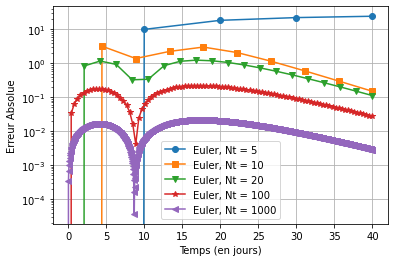

In [30]:
Nt_values = np.array([5, 10, 20, 100, 1000]) # choix du nombres de noeuds pour le maillage
tmax = 40

markers = "osv*<>"
plt.figure()
for i in range(len(Nt_values)):
    tvi = np.linspace(0., tmax, Nt_values[i])
    Xei = EulerExp(derivative_SIR, X0, tvi)
    Xsi = odeint(derivative_SIR, X0, tvi)
    plt.plot(tvi, np.abs((Xei[:, 1] - Xsi[:, 1])), markers[i] + "-", label = "Euler, Nt = {0}".format(Nt_values[i]))

# affichage du graphique
plt.grid()
plt.xlabel("Temps (en jours)")
plt.yscale('log')
plt.ylabel("Erreur Absolue")
plt.legend(loc = "best");
plt.show()

On retrouve un peu le meme graphe que pour SI avec en plus une chute au alentours de 7 jours car on a des maximums locaux ou l'erreur de calcul est très faible car ils sont assez large (en jours) au regard de taille du maillage.

### 6.2 Erreur Euler Implicite

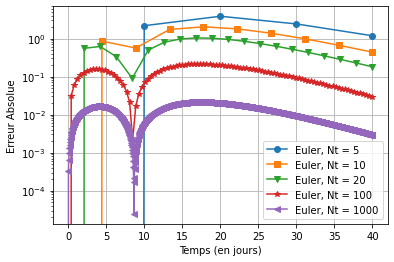

In [31]:
Nt_values = np.array([5, 10, 20, 100, 1000]) # choix du nombres de noeuds pour le maillage
tmax = 40

markers = "osv*<>"
plt.figure()
for i in range(len(Nt_values)):
    tvi = np.linspace(0., tmax, Nt_values[i])
    Xei = EulerImp(derivative_SIR, X0, tvi)
    Xsi = odeint(derivative_SIR, X0, tvi)
    plt.plot(tvi, np.abs((Xei[:, 1] - Xsi[:, 1])), markers[i] + "-", label = "Euler, Nt = {0}".format(Nt_values[i]))

# affichage du graphique
plt.grid()
plt.xlabel("Temps (en jours)")
plt.yscale('log')
plt.ylabel("Erreur Absolue")
plt.legend(loc = "best");
plt.show()

On remarque a nouveau que le schéma Euleur explicite commet moins d'erreur que Euler implicite et ceci pour taille de maillage. 

### 7/ Ordre de Convergence

### 7.1 Convergence Euler Explicite

D'apèrs le cours pour un schéma d'Euler Explicite nous avons une consistance en  $ \Delta   t$

En supposant la consistance de la forme $\;e = Cte (\Delta t) ^{p}$ on a en passant en au logarithme (ie passer en echelle logarithmique)  $\;log(e) = p \, log(\Delta t)+ log(Cte)$. En tracant $\;log(e)$ en fonction de $log(\Delta t)$ et en comparant la droite identité on pourra déduire la valeur de $p$. 

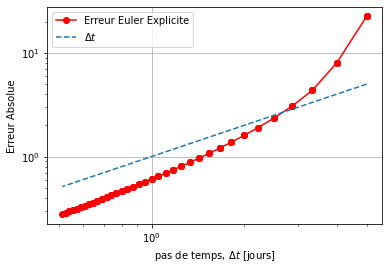

In [32]:
markers = "osv*<>"
tmax=20.
X0 = [400., 30., 0.]

Nt_values = np.linspace(5., 40., 100).astype(np.int32)
dt_values = tmax / (Nt_values -1)
Erreur = []
for i in range(len(Nt_values)):
    tvi = np.linspace(0., tmax, Nt_values[i])
    Xei = EulerExp(derivative_SIR, X0, tvi)
    xsi = odeint(derivative_SIR, X0, tvi)
    e = (Xei[:, 0] - xsi[:, 0]).std() # calcul de l'erreur
    Erreur.append(e)

plt.figure()
plt.plot(dt_values, Erreur, "or-", label = "Erreur Euler Explicite")
plt.plot(dt_values, dt_values, label = "$\Delta t$", linestyle ="--")
plt.legend()
plt.xlabel("pas de temps, $\Delta t$ [jours]")
plt.xscale('log')
plt.ylabel("Erreur Absolue")
plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.show()

Nous pouvons oberservers que lorsque le pas de temps depasses 2 jours, nous avons une erreur qui ne reste plus linéaire (plutot exp).

### 7.2 Convergence Euler Implicite


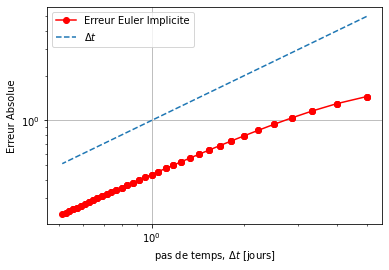

In [33]:
markers = "osv*<>" #markeur pour le graphique

tmax=20.
X0 = [400., 30., 0.]

Nt_values = np.linspace(5., 40., 100).astype(np.int32)
dt_values = tmax / (Nt_values -1)
Erreur = []
for i in range(len(Nt_values)):
    tvi = np.linspace(0., tmax, Nt_values[i])
    Xei = EulerImp(derivative_SIR, X0, tvi)
    xsi = odeint(derivative_SIR, X0, tvi)
    e = (Xei[:, 0] - xsi[:, 0]).std() # calcul de l'erreur
    Erreur.append(e)

# Réalisation de la figure
plt.figure()
plt.plot(dt_values, Erreur, "or-", label = "Erreur Euler Implicite")
plt.plot(dt_values, dt_values, label = "$\Delta t$", linestyle ="--")
plt.legend()
plt.xlabel("pas de temps, $\Delta t$ [jours]")
plt.xscale('log')
plt.ylabel("Erreur Absolue")
plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.show()

Il est interessant de remarquer que contrairement au schéma implicite l'erreur est n'augmente pas avec un pas de temps plus élevé. La méthode Euler implicite arrive à garder une certaines constance dans son erreur. 

### 8/ Conclusion modèle SIR

Le résolution numérique de modèle est indispensable comme nous l'avons dit (absence de solution théorique). Nous obtenons dans tout les cas le meme type de courbe que ca soit en Euler Explicite ou Implicite. L'erreur par rapport à la meilleur solution théorique (odeint) reste assez faible pour un maillage (en dessous de la journée).

# III. Conclusion

### 1/ Bilan

La résolution des EDP de manière informatique est d'une grande aide car elle permet d'avoir une idée précise des solutions possibles à des problèmes dont on arrive pas à exprimer une solution avec les fonctions usuelles.

Nous avons vu que même avec des schémas numériques rudimantaires (il existe des meilleurs schémas comme Runge-Kutta) les solutions numériques sont proches de la solution réelle (cf modèle SI). 

Il y a un réel interet de maitriser ces méthodes numériques pour réaliser des modélisatios afin de pouvoir prendre les bonnes mesures sanitaires par exemple. 

### 2/ Bibliographie

[1] Silva, C. J., & Torres, D. F. (2017). A SICA compartmental model in epidemiology with application to HIV/AIDS in Cape Verde. Ecological complexity, 30, 70-75.

[2] Cours de ST2: Modèles d’épidémie : point de vue déterministe, Sarah Lemler

[3] Cours EDP, Mr. Bouafia

[4] https://covid-ete.ouvaton.org/Rapport8_stochasticite.html

[5] http://images.math.cnrs.fr/Modelisation-d-une-epidemie-partie-1.html

[6] https://www.senat.fr/fileadmin/Fichiers/Images/opecst/quatre_pages/OPECST_modelisation_covid_19.pdf